In [1]:
import numpy as np
import sklearn as skl
import csv
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import scipy

stemmer = nltk.stem.PorterStemmer()

C:\Users\kingr\Anaconda2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
node_inf_raw = pd.read_csv("./node_information.csv")
node_inf = node_inf_raw.values
for i in range(len(node_inf)):
    if type(node_inf[i][3]) == float:
        node_inf[i][3] = []
    else:
        node_inf[i][3] = node_inf[i][3].split(", ")
    
    if type(node_inf[i][4]) == float:
        node_inf[i][4] = ''

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# compute TFIDF vector of each paper (abstract + title)
corpus_titles    = [' '.join([stemmer.stem(a) for a in nltk.tokenize.word_tokenize(element[2])]) for element in node_inf]
corpus_abstracts = [' '.join([stemmer.stem(a) for a in nltk.tokenize.word_tokenize(element[5])]) for element in node_inf]

vectorizer_titles   = TfidfVectorizer(stop_words="english", )
vectorizer_abstract = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF_titles    = vectorizer_titles.fit_transform(corpus_titles)
features_TFIDF_abstracts = vectorizer_abstract.fit_transform(corpus_abstracts)

In [5]:
ID_watching = 11

print(corpus_titles[ID_watching])
names = vectorizer_titles.get_feature_names()
for i in range(features_TFIDF_titles.shape[1]):
    a = features_TFIDF_titles[ID_watching,i]
    if a != 0.:
        print((names[i], a))

boundari liouvil field theori i boundari state and boundari two-point
('boundari', 0.8205676888258202)
('field', 0.17744920671991454)
('liouvil', 0.34246558288058593)
('point', 0.30330195104059937)
('state', 0.2582813861415513)
('theori', 0.13855115914185043)


In [6]:
def TFIDF_corr(ID1: int, ID2: int):
    i1, i2 = -1, -1
    for i, a in enumerate(node_inf[:, 0]):
        if a == ID1:
            i1 = i
            break
    for i, a in enumerate(node_inf[:, 0]):
        if a == ID2:
            i2 = i
            break
    
    return ( (features_TFIDF_titles[i1].dot(features_TFIDF_titles[i2].T))[0,0], (features_TFIDF_abstracts[i1].dot(features_TFIDF_abstracts[i2].T))[0,0])

In [7]:
train = pd.read_csv("paul_my_train.csv").values
X_train = train[:,:2]
y_train = train[:, 2]
data_node = []
data_notnode = []
data = []
sample_size = 1000
for i in range(sample_size):
    a = TFIDF_corr(X_train[i,0], X_train[i,1])
    if y_train[i] == 1:
        data_node.append(a)
    else:
        data_notnode.append(a)
    data.append(a)

data_node    = np.array(data_node)
data_notnode = np.array(data_notnode)

In [8]:
from sklearn.linear_model import LogisticRegression
csf = LogisticRegression()
csf.fit(data,y_train[:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Number of node elements : 546
Number of non-node elements : 454


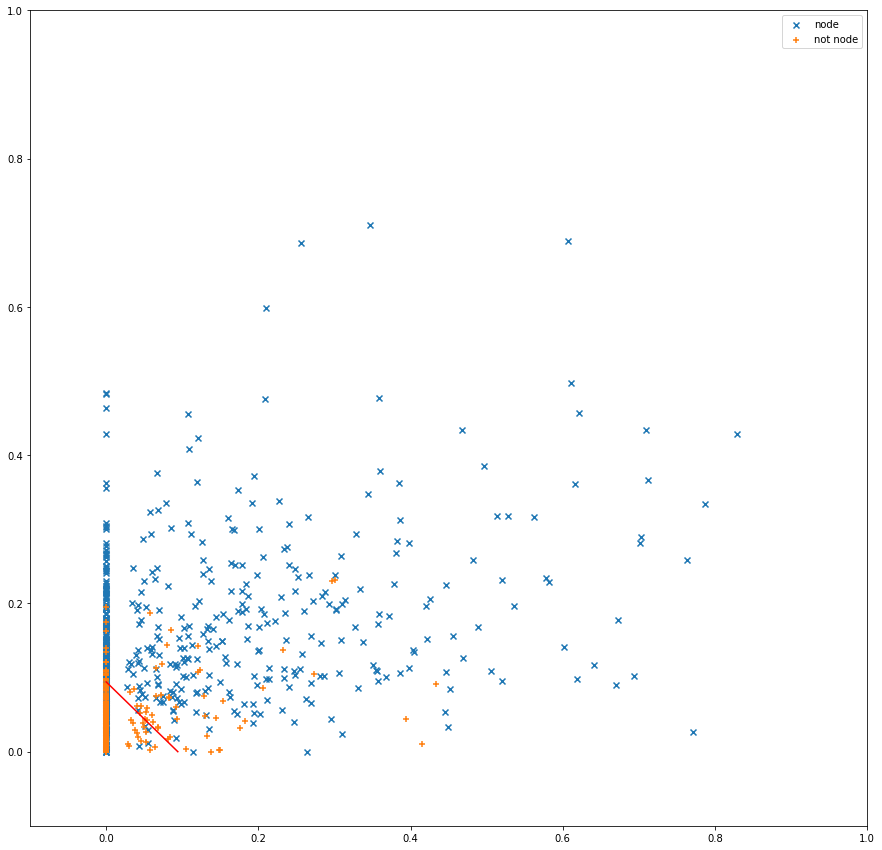

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-0.1,1)
ax.set_ylim(-0.1,1)
ax.scatter(data_node[:,0],data_node[:,1], marker='x', label='node')
ax.scatter(data_notnode[:,0],data_notnode[:,1], marker='+', label='not node')
ax.plot([0,-csf.intercept_[0]/csf.coef_[0,1]],[-csf.intercept_[0]/csf.coef_[0,1], 0], c='r')
ax.legend()
print("Number of node elements :"    , len(data_node))
print("Number of non-node elements :", len(data_notnode))
plt.show()

In [10]:
csf.score(data, y_train[:sample_size])

0.828

In [12]:
test = np.array(pd.read_csv("./paul_my_test.csv").values)
data_test = [TFIDF_corr(test[i,0], test[i,1]) for i in range(len(test))]
csf.score(data_test, test[:,2])

0.8152278985889865

In [33]:
kaggle = np.array(pd.read_csv("./testing_set.txt", delimiter=" ", header=None).values)
print(len(kaggle))

32648


In [34]:
data_kaggle = [TFIDF_corr(kaggle[i,0], kaggle[i,1]) for i in range(len(kaggle))]

In [35]:
predictions_kaggle = csf.predict(data_kaggle)

In [53]:
proba_kaggle = csf.predict_proba(data_kaggle)[:,1]
print(proba_kaggle)
id_sort = np.argsort(proba_kaggle)
print(id_sort)
print(len(id_sort))
print(id_sort[32648//2])
print(proba_kaggle[id_sort[32648//2]])
predictions_diff = (proba_kaggle >= proba_kaggle[id_sort[32648//2]])*1
print(predictions_diff)
print(sum(predictions_diff))

[0.56849737 0.91314538 0.75296637 ... 0.38358022 0.30742248 0.40382854]
[12545 24806 24798 ...  6824  1749 13247]
32648
6354
0.4688406357743372
[1 1 1 ... 0 0 0]
16324


In [36]:
import csv

In [54]:
with open("./paul_tfidf_linear.csv","w") as f:
    w = csv.writer(f)
    w.writerow(["ID","category"])
    print(len(predictions_kaggle))
    print(len(data_kaggle))
    for i, a in enumerate(predictions_diff):
        w.writerow([i, a])

32648
32648


In [ ]:
kaggle = pd.read_csv("./testing_set.txt", header=None, ).values
X_train = train[:,:2]
y_train = train[:, 2]
data_node = []
data_notnode = []
data = []
sample_size = 1000
for i in range(sample_size):
    a = TFIDF_corr(X_train[i,0], X_train[i,1])
    if y_train[i] == 1:
        data_node.append(a)
    else:
        data_notnode.append(a)
    data.append(a)

data_node    = np.array(data_node)
data_notnode = np.array(data_notnode)

### Doc2Voc

In [8]:
token_title =    [TaggedDocument(words=nltk.tokenize.word_tokenize(element[2].lower()),tags=[str(element[0])]) for i,element in enumerate(node_inf)]
token_abstract = [TaggedDocument(words=nltk.tokenize.word_tokenize(element[5].lower()),tags=[str(element[0])]) for i,element in enumerate(node_inf)]

In [9]:
print(token_title[:5])

[TaggedDocument(words=['compactification', 'geometry', 'and', 'duality'], tags=['1001']), TaggedDocument(words=['domain', 'walls', 'and', 'massive', 'gauged', 'supergravity', 'potentials'], tags=['1002']), TaggedDocument(words=['comment', 'on', 'metric', 'fluctuations', 'in', 'brane', 'worlds'], tags=['1003']), TaggedDocument(words=['moving', 'mirrors', 'and', 'thermodynamic', 'paradoxes'], tags=['1004']), TaggedDocument(words=['bundles', 'of', 'chiral', 'blocks', 'and', 'boundary', 'conditions', 'in', 'cft'], tags=['1005'])]


In [10]:
model_title = Doc2Vec(size=128,
                alpha=0.025, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
model_title.build_vocab(token_title)

model_abstract = Doc2Vec(size=128,
                alpha=0.025, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
model_abstract.build_vocab(token_abstract)

In [14]:
for epoch in range(100):
    model_title.train(token_title,
                total_examples=model_title.corpus_count,
                epochs=model_title.iter)
    model_abstract.train(token_abstract,
                total_examples=model_abstract.corpus_count,
                epochs=model_abstract.iter)
    
    model_title.alpha -= 0.0002
    model_abstract.alpha -= 0.0002
    
    model_title.min_alpha = model_title.alpha
    model_abstract.min_alpha = model_title.alpha

C:\Users\kingr\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.
C:\Users\kingr\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


In [18]:
print(model_title.docvecs['1001'])

[-0.04170485  0.10940319  0.34112358 -0.00554837 -0.16044605 -0.11121102
  0.8814343  -0.27961496 -0.08314432 -0.03922644  0.07017414  0.19535477
  0.01675409  0.4212751   0.11596388  0.18045197 -0.01355016  0.1543611
  0.0156306  -0.17538276  0.27050012 -0.0458751   0.02364712  0.13725783
 -0.16368839  0.31912568  0.20277877 -0.25423074 -0.15933204  0.20103739
 -0.13856104 -0.02332677  0.13542129  0.21218774 -0.33530957 -0.04329453
 -0.2657011   0.10978931  0.14617325  0.10272751 -0.02632141  0.09533675
  0.22650513  0.39330477 -0.1394688  -0.11786289 -0.46929154 -0.38594934
  0.31353968  0.33796778 -0.00637685 -0.21875593  0.15265699  0.1767527
 -0.3961496   0.5214232   0.2582995   0.02535458  0.06755373  0.54435235
 -0.20135671  0.13042274 -0.28979266 -0.29326704  0.18395644  0.24668041
  0.03886151 -0.01012071  0.22489995  0.37312758  0.07225244 -0.01827517
  0.20031941  0.1655658  -0.5131884  -0.23582391 -0.72362286  0.05312482
  0.07841974 -0.08282308  0.5092957  -0.21498539 -0.6

In [15]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

training_set_paul = np.array(pd.read_csv("paul_my_train.csv").values)
testing_set_paul = np.array(pd.read_csv("paul_my_test.csv").values)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
titlefeatures_paul = []
for citation in training_set_paul:
    d = scipy.spatial.distance.cosine(model_title.docvecs[str(citation[0])],model_title.docvecs[str(citation[1])])
    titlefeatures_paul.append(d)

In [22]:
titlefeaturestest_paul = []
for citation in testing_set_paul:
    d = scipy.spatial.distance.cosine(model_title.docvecs[str(citation[0])],model_title.docvecs[str(citation[1])])
    titlefeaturestest_paul.append(d)

In [23]:
titlefeatures = []
for citation in training_set:
    d = scipy.spatial.distance.cosine(model_title.docvecs[str(citation[0])],model_title.docvecs[str(citation[1])])
    titlefeatures.append(d)

In [24]:
titlefeaturestest = []
for citation in testing_set:
    d = scipy.spatial.distance.cosine(model_title.docvecs[str(citation[0])],model_title.docvecs[str(citation[1])])
    titlefeaturestest.append(d)

In [25]:
abstractfeatures_paul = []
for citation in training_set_paul:
    d = scipy.spatial.distance.cosine(model_abstract.docvecs[str(citation[0])],model_abstract.docvecs[str(citation[1])])
    abstractfeatures_paul.append(d)

In [26]:
abstractfeaturestest_paul = []
for citation in testing_set_paul:
    d = scipy.spatial.distance.cosine(model_abstract.docvecs[str(citation[0])],model_abstract.docvecs[str(citation[1])])
    abstractfeaturestest_paul.append(d)

In [27]:
abstractfeatures = []
for citation in training_set:
    d = scipy.spatial.distance.cosine(model_abstract.docvecs[str(citation[0])],model_abstract.docvecs[str(citation[1])])
    abstractfeatures.append(d)

In [28]:
abstractfeaturestest = []
for citation in testing_set:
    d = scipy.spatial.distance.cosine(model_abstract.docvecs[str(citation[0])],model_abstract.docvecs[str(citation[1])])
    abstractfeaturestest.append(d)

In [31]:
abstractfeaturestest_paul[:10]

[0.8488564044237137,
 0.8575503975152969,
 0.8520327210426331,
 0.5343081951141357,
 0.8329092264175415,
 0.8771824017167091,
 0.905466690659523,
 0.840924009680748,
 0.8899462819099426,
 0.5304320752620697]

In [32]:
with open("./louis_training_doc2voc.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["title","abstract"])
    for i in range(len(titlefeatures)):
        writer.writerow([titlefeatures[i],abstractfeatures[i]])

In [34]:
with open("./louis_testing_doc2voc.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["title","abstract"])
    for i in range(len(titlefeaturestest)):
        writer.writerow([titlefeaturestest[i],abstractfeaturestest[i]])

In [35]:
with open("./louis_training_doc2voc_sample.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["title","abstract"])
    for i in range(len(titlefeatures_paul)):
        writer.writerow([titlefeatures_paul[i],abstractfeatures_paul[i]])

In [36]:
with open("./louis_testing_doc2voc_sample.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["title","abstract"])
    for i in range(len(titlefeaturestest_paul)):
        writer.writerow([titlefeaturestest_paul[i],abstractfeaturestest_paul[i]])